# FSPS Examples for AST2040

Documentation for the Python FSPS bindings is here: 

http://dfm.io/python-fsps/current/stellarpop_api/#api-reference

To use the Python bindings you first need to install Charlie Conroy's Flexible Stellar Population Synthsis (FSPS) Fortran code, which you can find here:

https://github.com/cconroy20/fsps

These are the papers which describe FSPS:

- Conroy, Gunn, & White 2009, ApJ, 699, 486
- Conroy & Gunn 2010, ApJ, 712, 833

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import fsps
import pandas as pd

plt.rcParams['figure.dpi']= 100
plt.style.use('sm.mplstyle')
plt.style.use('dark_background')

Let's model the simplest possible galaxy: a simple stellar population (basically, a gigantic globular cluster). This thing has a star formation history that is a delta function... all the stars form in a single burst. This is totally unrealistic of course but it's useful reference case. You should play with other star-formation histories on your own!

In [2]:
%%time
sp = fsps.StellarPopulation(compute_vega_mags=False, 
                            zcontinuous=1, 
                            sfh=0, 
                            logzsol=0.0, 
                            dust_type=2, 
                            dust2=0.2)

CPU times: user 21.3 s, sys: 689 ms, total: 22 s
Wall time: 21.8 s


Now define the filter set we want to use. We'll use the Sloan Survey filter set as it's such a common filter set these days, it's almost a universal standard for visible-wavelength telescopes.

In [3]:
%%time
sdss_bands = fsps.find_filter('sdss')
print(sdss_bands)

['sdss_u', 'sdss_g', 'sdss_r', 'sdss_i', 'sdss_z']
CPU times: user 112 µs, sys: 5 µs, total: 117 µs
Wall time: 108 µs


The first call to `get_mags()` will take a long time, as the module is calculating everything for everything! Once it has done that the results are stored in the object though.

In [4]:
%%time
result = sp.get_mags(bands=sdss_bands)

CPU times: user 1min 51s, sys: 507 ms, total: 1min 51s
Wall time: 1min 51s


Subsequent calls to `get_mags()` are very quick.

In [5]:
%%time
sp.get_mags(tage=1.0, redshift=1.0, bands=sdss_bands)

CPU times: user 29.2 ms, sys: 11.8 ms, total: 41.1 ms
Wall time: 40.8 ms


array([53.78830041, 52.1202101 , 50.45429077, 49.41057591, 48.49674713])

Remember that the modelled stellar population has a mass of 1 solar mass! So you need to multiply it by the mass you want. If you're working in mag units, you need to subtract off 2.5*log10(mass in solar units).

In [19]:
%%time
-2.5*math.log10(10**10.4) + sp.get_mags(tage=1.0, 
                                        redshift=1.0, 
                                        bands=sdss_bands)

CPU times: user 25.6 ms, sys: 0 ns, total: 25.6 ms
Wall time: 25.5 ms


array([27.78830041, 26.1202101 , 24.45429077, 23.41057591, 22.49674713])

The `sp` object stores complete spectra!

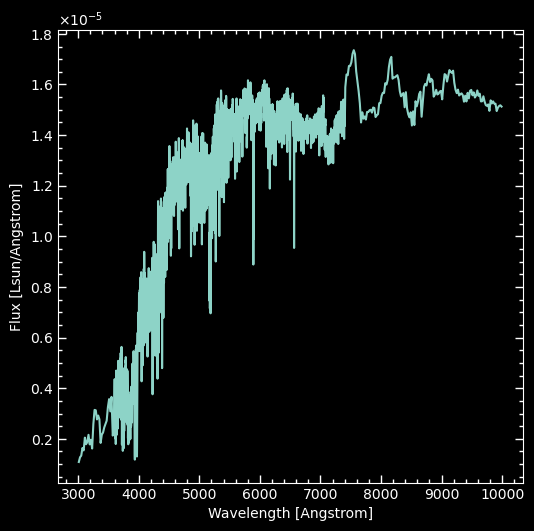

CPU times: user 682 ms, sys: 16 ms, total: 698 ms
Wall time: 698 ms


In [9]:
%%time

wave, spec = sp.get_spectrum(tage=13.5, peraa=True);

# Plot the spectrum in the range 3000A to 10,000A
idx_low = np.searchsorted(wave, 3000, side="left");
idx_high = np.searchsorted(wave, 10000, side="left");
xdata = wave[idx_low:idx_high]
ydata = spec[idx_low:idx_high]

plt.plot(xdata,ydata);
plt.xlabel("Wavelength [Angstrom]")
plt.ylabel("Flux [Lsun/Angstrom]")
ax = plt.gca()
ax.ticklabel_format(axis='y',style='sci',scilimits=(0,0))
ax.yaxis.major.formatter._useMathText = True
plt.show()

## A cosmologically consistent galaxy (sort-of)

Let's assume our toy galaxy is born at z=5. How old was the Universe?

In [10]:
from astropy.cosmology import WMAP9 as cosmo

age_of_universe_when_galaxy_was_born = cosmo.age(5)
age_of_universe_when_galaxy_was_born

<Quantity 1.19002429 Gyr>

To get the age of the galaxy, we just just get the age of the Universe at a given redshift and subtract off the time at which the galaxy was born. 

In [11]:
redshifts = np.arange(0.1,5,0.2)
redshifts

array([0.1, 0.3, 0.5, 0.7, 0.9, 1.1, 1.3, 1.5, 1.7, 1.9, 2.1, 2.3, 2.5,
       2.7, 2.9, 3.1, 3.3, 3.5, 3.7, 3.9, 4.1, 4.3, 4.5, 4.7, 4.9])

In [12]:
age_of_galaxy = cosmo.age(redshifts) - age_of_universe_when_galaxy_was_born
age_of_galaxy

<Quantity [11.26351772,  9.11736687,  7.46661185,  6.17937037,  5.16178366,
            4.3463132 ,  3.68407837,  3.13946301,  2.68628373,  2.30508575,
            1.9812448 ,  1.70363532,  1.46369232,  1.25474568,  1.07154362,
            0.9099079 ,  0.76648183,  0.63854396,  0.523869  ,  0.42062274,
            0.32728213,  0.24257359,  0.16542528,  0.09492959,  0.03031365] Gyr>

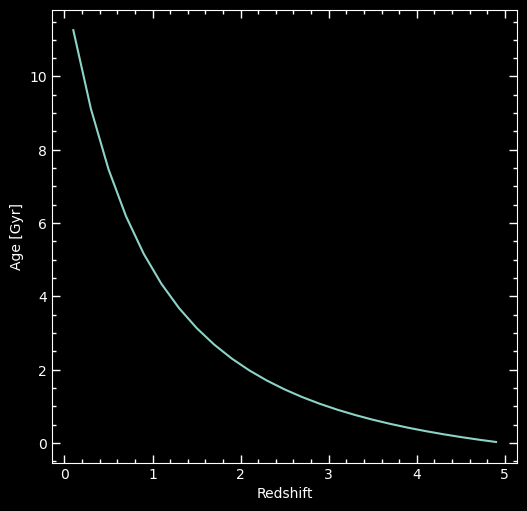

In [13]:
plt.plot(redshifts,age_of_galaxy)
plt.xlabel("Redshift")
plt.ylabel("Age [Gyr]");

So now the hard work is done and we can work the galaxy magnitudes out in a nicely self-consistent way.

In [20]:
logmass_of_galaxy = 10.4

# Define the dataframe structure and create a template.
col = {'Redshift': [], 'Age': [], 'sdss_u': [], 'sdss_g': [], 
       'sdss_r': [], 'sdss_i': [], 'sdss_z': []}
df = pd.DataFrame(data=col)

for i in np.arange(len(redshifts)):
    mags=sp.get_mags(tage=age_of_galaxy[i].value, 
                     redshift=redshifts[i], 
                     bands=sdss_bands)
    mags = mags -2.5*math.log10(10**logmass_of_galaxy)

    # Add the information to the data frame    
    col = {'Redshift': [redshifts[i]], 
           'Age': [age_of_galaxy[i].value], 
           'sdss_u': [mags[0]], 
           'sdss_g': [mags[1]], 
           'sdss_r': [mags[2]], 
           'sdss_i': [mags[3]], 
           'sdss_z': [mags[4]]}
    new_df = pd.DataFrame(data=col)
    df = df.append(new_df)

Now that we have a dataframe with all the information it's easy to make plots.

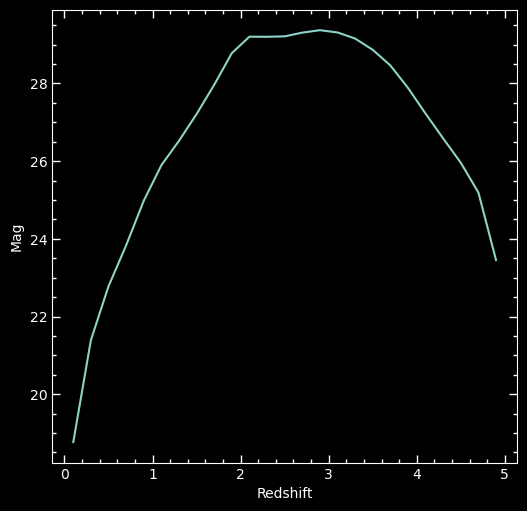

In [21]:
plt.plot(df['Redshift'].to_numpy(),df['sdss_i'].to_numpy())
plt.xlabel("Redshift")
plt.ylabel("Mag");